# 3.6 softmax回归的从零开始实现


softmax回归的理论知识
https://trickygo.github.io/Dive-into-DL-TensorFlow2.0/#/chapter03_DL-basics/3.4_softmax-regression

https://blog.csdn.net/bitcarmanlee/article/details/82320853

- 3.6.1 获取和读取数据

from tensorflow.keras.datasets import fashion_mnist

- 3.6.2 初始化模型参数

w = shape=(num_inputs, num_outputs)

- 3.6.3 实现 softmax 运算

- 3.6.4 定义模型

- 3.6.5 定义损失函数
 
- 3.6.6 计算分类准确率

- 3.6.7 训练模型

- 3.6.8 预测

---


In [188]:
import tensorflow as tf
import numpy as np
print(tf.__version__) # 2.2.0

2.2.0


3.6.1 获取和读取数据
---

In [189]:
from tensorflow.keras.datasets import fashion_mnist

batch_size=256
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = tf.cast(x_train, tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
x_test = tf.cast(x_test,tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_iter = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


3.6.2 初始化模型参数
---

每个样本: 28x28像素点，共计784特征，每个像素点2通道图像

输出层的输出个数为10，那么该单层神经网络的权重和偏差尺寸为(784,10)和(1,10)

$$\hat{y} = X_{(m,784)} W_{(784,10)} + b_{(1,10)}$$



In [190]:
num_inputs = 784
num_outputs = 10
W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs), mean=0, stddev=0.01, dtype=tf.float32))
b = tf.Variable(tf.zeros(num_outputs, dtype=tf.float32))


3.6.3 实现 softmax 运算（理解为激活函数）
---

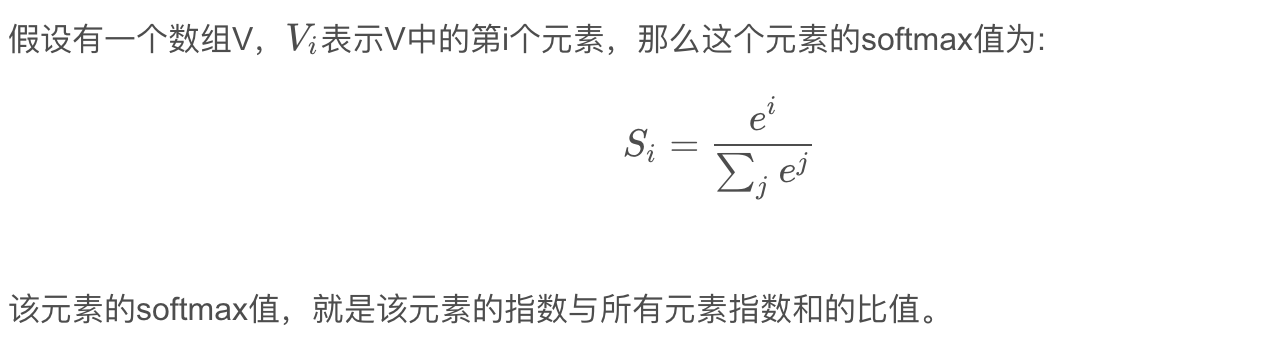

参考资料：https://blog.csdn.net/bitcarmanlee/article/details/82320853


In [191]:
# 矩阵logits的行数是样本数，列数是输出个数
# softmax运算的输出矩阵中的任意一行元素代表了一个样本在各个输出类别上的预测概率。
def softmax(logits, axis=-1):
    logits =tf.cast(x=logits,dtype=tf.float32)#需要浮点数类型
    return tf.exp(logits)/tf.reduce_sum(tf.exp(logits), axis, keepdims=True)
    

3.6.4 定义模型
---

$$\hat{y} = X_{(m,784)} W_{(784,10)} + b_{(1,10)}$$

In [192]:
# x_train尺寸测试
print(x_train.shape)
    # reshape
print(tf.reshape(x_train,shape=(-1,W.shape[0])).shape) # W.shape[0]==num_inputs


(60000, 28, 28)
(60000, 784)


In [193]:
def net(X):
    logits = tf.matmul(tf.reshape(X, shape=(-1, W.shape[0])), W) + b
    return softmax(logits)


3.6.5 定义损失函数
---

$Loss_i=−\log{y_i} \quad y_i表示标签的预测概率。直观地讲，预测概率约接近1，那么损失越小$ 

参考资料：https://blog.csdn.net/bitcarmanlee/article/details/82320853

通过softmax运算，其输出矩阵中的任意一行元素代表了一个样本在各个输出类别上的预测概率。

现在，为了得到标签的预测概率，我们可以使用boolean_mask函数和one_hot函数

In [194]:
# 测试一下one_hot是什么？
one_hot = tf.one_hot(indices=tf.constant([1,3]),depth=4)
one_hot

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [195]:
# 测试一下boolean_mask是什么?
tf.boolean_mask(tensor=tf.constant([[0.,1.,2.,3.],[0.,1.,2.,3.]]),mask=one_hot)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 3.], dtype=float32)>

In [196]:
def cross_entropy(y_hat,y):
    # 对标签进行one_hot
    y = tf.one_hot(indices=y,depth=y_hat.shape[-1]) 
    y = tf.cast(x=y,dtype=tf.float32)
    return -tf.math.log(tf.boolean_mask(tensor=y_hat,mask=y))   

In [197]:
# 测试一下 交叉熵损失函数
cross_entropy(tf.constant([[0.1,0.4,0.5],[0.7,0.2,0.1]]),tf.constant([2,1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.6931472, 1.609438 ], dtype=float32)>

3.6.6 计算分类准确率
---

分类准确率即正确预测数量与总预测数量之比。

y_hat 为所有样本的预测值,尺寸为(num_examples,num_outputs)

y 尺寸为(num_examples,1)


tf.argmax(): Returns the index with the largest value across axes of a tensor 返回值为index

In [200]:
# 评价模型在该数据集上的准确率
# 描述,对于tensorflow2中，比较的双方必须类型都是int型，所以要将输出和标签都转为int型

def evaluate_accuracy(data_iter,net):
    acc_num,n = 0.0,0
    for _,(X,y) in enumerate(data_iter):
        y = tf.cast(y,tf.int64)
        acc_num+=np.sum(tf.cast(tf.argmax(net(X),axis=1),dtype=tf.int64)==y)
        n+=X.shape[0] # 样本数
    return acc_num  / n
    

3.6.7 训练模型(重要)
---

In [199]:
num_epochs, lr = 5, 0.1
# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = tf.reduce_sum(loss(y_hat, y))
            grads = tape.gradient(l, params)
            if trainer is None:
                # 如果没有传入优化器，则使用原先编写的小批量随机梯度下降
                for i, param in enumerate(params):
                    param.assign_sub(lr * grads[i] / batch_size)
            else:
                # tf.keras.optimizers.SGD 直接使用是随机梯度下降 theta(t+1) = theta(t) - learning_rate * gradient
                # 这里使用批量梯度下降，需要对梯度除以 batch_size, 对应原书代码的 trainer.step(batch_size)
                trainer.apply_gradients(zip([grad / batch_size for grad in grads], params))  

            y = tf.cast(y, dtype=tf.float32)
            train_l_sum += l.numpy()
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.int64)).numpy()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

trainer = tf.keras.optimizers.SGD(lr)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)


Instructions for updating:
Use tf.identity instead.
epoch 1, loss 0.7846, train acc 0.750, test acc 0.792
epoch 2, loss 0.5711, train acc 0.812, test acc 0.812
epoch 3, loss 0.5259, train acc 0.825, test acc 0.819
epoch 4, loss 0.5016, train acc 0.832, test acc 0.825
epoch 5, loss 0.4857, train acc 0.836, test acc 0.828


3.6.8 预测
---

训练完成后，现在就可以演示如何对图像进行分类了。给定一系列图像（第三行图像输出），我们比较一下它们的真实标签（第一行文本输出）和模型预测结果（第二行文本输出）。

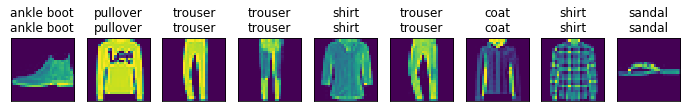

In [212]:
import matplotlib.pyplot as plt
X,y = iter(test_iter).next()

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images,labels):
    _,figs = plt.subplots(1,len(images),figsize=(12,12))
    for f,img,lbl in zip(figs,images,labels):
        f.imshow(tf.reshape(img,shape=(28,28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
        
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(tf.argmax(net(X),axis=1).numpy())
titles = [true+'\n'+pred for true,pred in zip(true_labels,pred_labels)]

show_fashion_mnist(X[0:9],titles[0:9])

结果
---

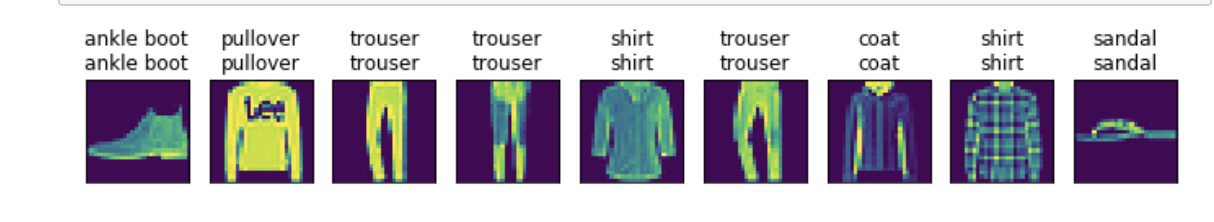